# Tutorial: Spatial Clustering with Iterative Feature Selection (CiCLODS)

This notebook demonstrates a custom iterative clustering algorithm designed for spatial transcriptomics data: **CiCLODS** (*Clustering in Critical \& Low-Dimensional Subspace*).

### 🎯 The Problem

Standard spatial analysis pipelines (e.g., PCA  K-Means) often struggle to identify clean spatial domains because:

1. **Noise:** They rely on global High Variance Genes (HVGs), many of which may be biologically irrelevant or noisy.
2. **Disconnect:** Feature selection happens *before* clustering, meaning the genes selected aren't necessarily the best ones for distinguishing the specific tissues present.
3. **Spatial Ignorance:** Standard clustering treats cells as independent bags of molecules, ignoring their physical location.

### 💡 The Solution: CiCLODS

CiCLODS solves this by coupling feature selection and clustering into an optimization loop:

* **Iterative Selection:** It repeatedly selects genes that best distinguish the *current* cluster assignments.
* **Positional Encoding (PE):** It injects spatial coordinates (as sinusoidal waves) directly into the feature matrix, acting as a "spatial prior" to encourage contiguous domains.

### ⚖️ The Benchmark: Variance-Matched PCA

To evaluate CiCLODS fairly, we compare it against a standard PCA + K-Means pipeline. However, we ensure a fair fight by using a **Variance-Matched Baseline**:

* If CiCLODS uses a budget of 2,000 specific genes, we calculate the total statistical variance those genes represent.
* We then restrict the PCA baseline to use only enough Principal Components (PCs) to match that exact variance.
* This ensures we are comparing the *quality* of the features, not just the quantity of information.

---

### Workflow

1. **Preprocessing:** Normalize data and filter to a broad set of initial HVGs.
2. **CiCLODS:** Run the iterative model with Positional Encoding (`use_pe=True`).
3. **Baseline:** Run standard PCA constrained to the same information budget.
4. **Evaluation:** Compare both methods against Ground Truth using the **Adjusted Rand Index (ARI)**.
5. **Visualization:** Plot the resulting spatial domains side-by-side.

---

**Some Helper Function to compare with PCA**


In [1]:
import numpy as np
import scanpy as sc
from sklearn.cluster import KMeans

# ==========================================
def run_pca_baseline(adata_in, selected_genes, n_clusters):
    """Runs PCA matched to the variance of selected_genes."""
    print(f"--- Running Variance-Matched PCA ---")
    adata = adata_in.copy()

    # Standardize for "Information Content" Comparison
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)

    # Calculate Target Ratio
    total_var = adata.n_vars
    target_var = np.sum(adata.var_names.isin(selected_genes))
    target_ratio = target_var / total_var

    # Run PCA
    sc.tl.pca(adata, n_comps=150)
    cum_var = np.cumsum(adata.uns['pca']['variance_ratio'])
    n_pcs = np.searchsorted(cum_var, target_ratio) + 1
    if n_pcs > 150: n_pcs = 150

    print(f"    > Target Ratio: {target_ratio:.2%} (Matched by {n_pcs} PCs)")

    # Cluster
    X_pca = adata.obsm['X_pca'][:, :n_pcs]
    kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
    kmeans.fit(X_pca)

    adata.obs['pca_baseline'] = kmeans.labels_.astype(str)
    return adata, n_pcs

# ==========================================
# 5. VISUALIZATION
# ==========================================
def compare_results(adata, gt_key=None):
    """Plots CiCLODS vs PCA side-by-side with ARI scores."""
    keys = ['ciclods', 'pca_baseline']
    titles = ['CiCLODS', 'Matched PCA']

    # Calculate ARI if Ground Truth exists
    if gt_key and gt_key in adata.obs:
        mask = ~adata.obs[gt_key].isna()
        ari1 = adjusted_rand_score(adata.obs.loc[mask, gt_key], adata.obs.loc[mask, 'ciclods'])
        ari2 = adjusted_rand_score(adata.obs.loc[mask, gt_key], adata.obs.loc[mask, 'pca_baseline'])
        titles[0] += f"\nARI={ari1:.3f}"
        titles[1] += f"\nARI={ari2:.3f}"
        keys.insert(0, gt_key)
        titles.insert(0, "Ground Truth")

    # Plot
    x = adata.obsm['spatial'][:, 1]
    y = -adata.obsm['spatial'][:, 0] # Flip Y for image orientation

    fig, axes = plt.subplots(1, len(keys), figsize=(4*len(keys), 4))
    if len(keys) == 1: axes = [axes]

    for i, key in enumerate(keys):
        ax = axes[i]
        labels = adata.obs[key].values
        unique = np.unique(labels)
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique)))

        for lbl, c in zip(unique, colors):
            mask = (labels == lbl)
            ax.scatter(x[mask], y[mask], c=[c], s=10, label=lbl, edgecolors='none')

        ax.set_title(titles[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

**Comparing CiCLoDS with PCA**

--- Preprocessing Data (Target HVG: 10000) ---
    > Data Shape: (684, 10373)
    > Max value check (should be >10 if linear): 24.0
--- Running CiCLODS (Kx=1024) ---
(684, 10000)
--- Running Variance-Matched PCA ---
    > Target Ratio: 9.87% (Matched by 3 PCs)

CiCLODS ARI:     0.5220
Matched PCA ARI: 0.3840



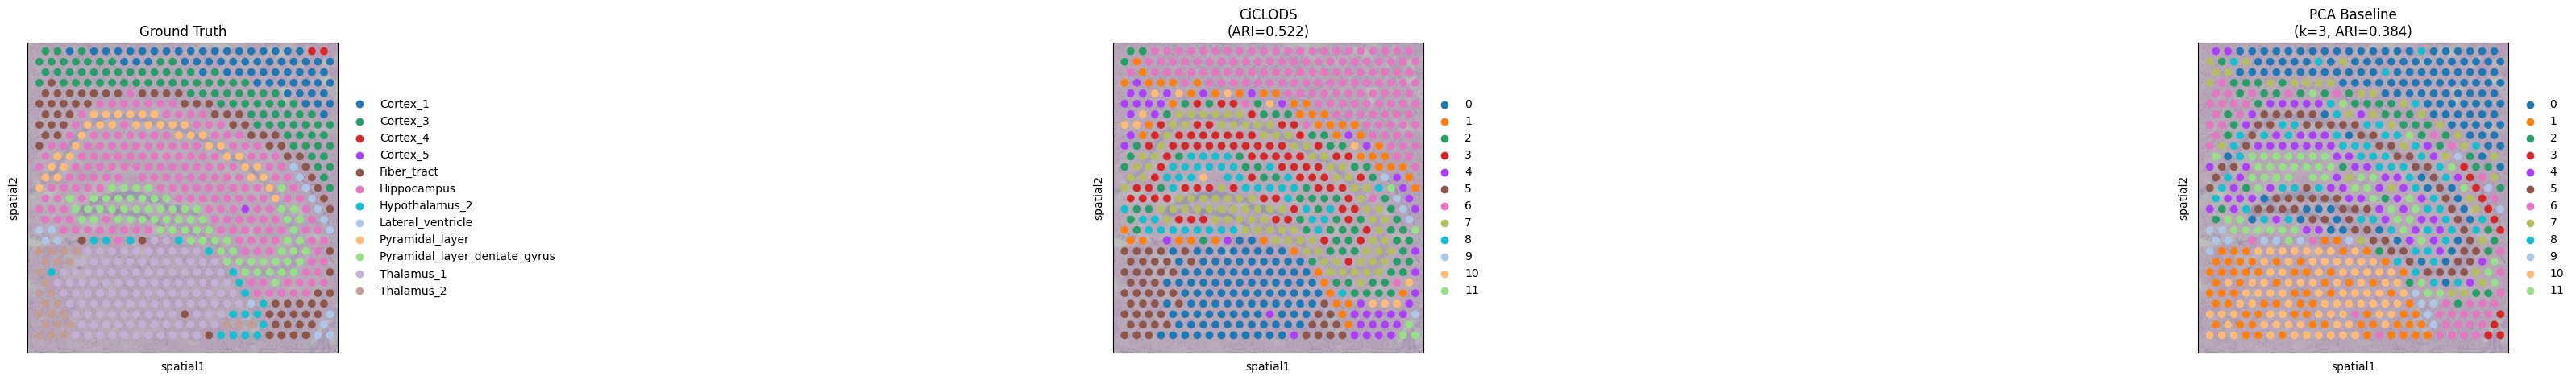

In [3]:
import squidpy as sq
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from src.ciclods_codule import run_ciclods_model, preprocess_spatial_data
# ==========================================
# EXPERIMENT EXECUTION
# ==========================================

# 1. Load Data
adata_orig = sq.datasets.visium_hne_adata_crop()

# 2. Preprocess
## Preprocess
adata_ready = preprocess_spatial_data(adata_orig, n_hvg=10000)

# 3. Parameters
Ky = 12   # Clusters
Kx = 1024 # Genes

# 4. Run CiCLODS
adata_res, selected_genes = run_ciclods_model(
    adata_ready,
    Ky=Ky,
    Kx=Kx,
    use_pe=True,
    pe_weight=0.1
)

# 5. Run Comparison (Variance-Matched PCA)
adata_res, n_pcs = run_pca_baseline(
    adata_res,
    selected_genes,
    n_clusters=Ky
)

# ==========================================
# SCORING (ARI)
# ==========================================
gt_key = 'cluster'
titles = ['Ground Truth', 'CiCLODS', 'PCA Baseline']

if gt_key in adata_res.obs:
    # Filter out background spots (where ground truth is NaN)
    mask = ~adata_res.obs[gt_key].isna()

    # Calculate Scores
    ari_ciclods = adjusted_rand_score(adata_res.obs.loc[mask, gt_key], adata_res.obs.loc[mask, 'ciclods'])
    ari_pca = adjusted_rand_score(adata_res.obs.loc[mask, gt_key], adata_res.obs.loc[mask, 'pca_baseline'])

    # Print to Console
    print("\n" + "="*30)
    print(f"CiCLODS ARI:     {ari_ciclods:.4f}")
    print(f"Matched PCA ARI: {ari_pca:.4f}")
    print("="*30 + "\n")

    # Update Plot Titles with Scores
    titles[1] += f"\n(ARI={ari_ciclods:.3f})"
    titles[2] += f"\n(k={n_pcs}, ARI={ari_pca:.3f})"

# ==========================================
# PLOTTING
# ==========================================
plt.rcParams["figure.figsize"] = (12, 5)

sq.pl.spatial_scatter(
    adata_res,
    color=[gt_key, 'ciclods', 'pca_baseline'],
    title=titles,
    wspace=0.3,
    img_alpha=0.5
)